In [20]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Configuration
DATA_ROOTS = [
    # r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB",
    r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2"
]
BATCH_SIZE = 8
NUM_WORKERS = 0  # Optimize based on CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class ParkinsonSpectrogramDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        if isinstance(root_dirs, str):  # If a single path is given, convert it to a list
            root_dirs = [root_dirs]
        self.root_dirs = root_dirs
        self.transform = transform
        self.samples = self._load_samples()
        
    def _load_samples(self):
        samples = []
        for root_dir in self.root_dirs:
            for class_name in ['HC', 'PD']:
                class_dir = os.path.join(root_dir, class_name)
                if not os.path.exists(class_dir):
                    continue

                # Traverse subfolders inside HC/PD
                for patient_folder in os.listdir(class_dir):
                    patient_path = os.path.join(class_dir, patient_folder)
                    if os.path.isdir(patient_path):  # Ensure it's a directory
                        for img_file in os.listdir(patient_path):
                            if img_file.lower().endswith('.png'):  # Only PNG images
                                img_path = os.path.join(patient_path, img_file)
                                samples.append((img_path, 0 if class_name == 'HC' else 1))

        print(f"‚úÖ Loaded {len(samples)} samples from {self.root_dirs}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            img = self.transform(img)
        return img, label

# Data Transforms
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Only slight translations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize between -1 and 1
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create Datasets (Loading from both MDVR & Italian datasets)
train_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'train') for root in DATA_ROOTS], transform=train_transform)
val_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'val') for root in DATA_ROOTS], transform=test_transform)
test_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'test') for root in DATA_ROOTS], transform=test_transform)

# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"‚úÖ DataLoaders ready! Using device: {DEVICE}")

‚úÖ Loaded 12114 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2/train']
‚úÖ Loaded 2364 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2/val']
‚úÖ Loaded 4291 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2/test']
‚úÖ DataLoaders ready! Using device: cuda


In [21]:
# üöÄ Full Pipeline for Pretrained DenseNet121 with RGB Spectrograms

import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm import tqdm

# ============================
# ‚úÖ Configuration
# ============================
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB"
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB"
# BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 100
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ‚úÖ Data Transforms
# ============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize from (496x200) to 224x224 for DenseNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ============================
# ‚úÖ Dataset and DataLoader
# ============================
# train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
# val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
# test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ============================
# ‚úÖ Model Definition
# ============================


# # mFrom here 
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CustomDenseNet121, self).__init__()
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        self.features = base_model.features  # All layers up to final conv
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc1 = nn.Linear(base_model.classifier.in_features, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.classifier(x)
        return x

model = CustomDenseNet121(num_classes=NUM_CLASSES).to(DEVICE)
# #To here


# # from here
# model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
# model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
# model = model.to(DEVICE)
# # to here

# ============================
# ‚úÖ Loss and Optimizer
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============================
# ‚úÖ Training and Validation Loop
# ============================


# Store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracy = None  # Final test accuracy



def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        loop = tqdm(loader, desc="Validation", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

# ============================
# ‚úÖ Run Training
# ============================
for epoch in range(EPOCHS):
    print(f"\nüåü Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    
    print(f"\nüìà Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# ============================
# ‚úÖ Testing
# ============================
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100. * correct / total
    print(f"\n‚úÖ Test Accuracy: {acc:.2f}%")
    return acc  # <- Return value for test_accuracy

# Run test
print("\nüöÄ Testing best model...")
test_accuracy = test_model(model, test_loader)


üåü Epoch 1/100



üìà Train Loss: 0.1707, Acc: 0.9332 | Val Loss: 0.2141, Acc: 0.9260

üåü Epoch 2/100



üìà Train Loss: 0.0741, Acc: 0.9741 | Val Loss: 0.2105, Acc: 0.9429

üåü Epoch 3/100



üìà Train Loss: 0.0506, Acc: 0.9845 | Val Loss: 0.2173, Acc: 0.9391

üåü Epoch 4/100



üìà Train Loss: 0.0462, Acc: 0.9839 | Val Loss: 0.3509, Acc: 0.8883

üåü Epoch 5/100



üìà Train Loss: 0.0407, Acc: 0.9856 | Val Loss: 0.1763, Acc: 0.9416

üåü Epoch 6/100



üìà Train Loss: 0.0362, Acc: 0.9872 | Val Loss: 0.2013, Acc: 0.9530

üåü Epoch 7/100



üìà Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.2561, Acc: 0.9103

üåü Epoch 8/100



üìà Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.1296, Acc: 0.9459

üåü Epoch 9/100



üìà Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.2116, Acc: 0.9370

üåü Epoch 10/100



üìà Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1348, Acc: 0.9653

üåü Epoch 11/100



üìà Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.2361, Acc: 0.9607

üåü Epoch 12/100



üìà Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.1352, Acc: 0.9683

üåü Epoch 13/100



üìà Train Loss: 0.0237, Acc: 0.9918 | Val Loss: 0.1135, Acc: 0.9624

üåü Epoch 14/100



üìà Train Loss: 0.0172, Acc: 0.9935 | Val Loss: 0.2634, Acc: 0.9306

üåü Epoch 15/100



üìà Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.2093, Acc: 0.9361

üåü Epoch 16/100



üìà Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.2507, Acc: 0.9302

üåü Epoch 17/100



üìà Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1620, Acc: 0.9670

üåü Epoch 18/100



üìà Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.2214, Acc: 0.9514

üåü Epoch 19/100



üìà Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0889, Acc: 0.9818

üåü Epoch 20/100



üìà Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.2099, Acc: 0.9607

üåü Epoch 21/100



üìà Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.3406, Acc: 0.9184

üåü Epoch 22/100



üìà Train Loss: 0.0156, Acc: 0.9955 | Val Loss: 0.2439, Acc: 0.9408

üåü Epoch 23/100



üìà Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.3096, Acc: 0.9420

üåü Epoch 24/100



üìà Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1341, Acc: 0.9657

üåü Epoch 25/100



üìà Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1431, Acc: 0.9649

üåü Epoch 26/100



üìà Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1219, Acc: 0.9759

üåü Epoch 27/100



üìà Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.2220, Acc: 0.9399

üåü Epoch 28/100



üìà Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.4167, Acc: 0.9158

üåü Epoch 29/100



üìà Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.2557, Acc: 0.9450

üåü Epoch 30/100



üìà Train Loss: 0.0129, Acc: 0.9971 | Val Loss: 0.1422, Acc: 0.9683

üåü Epoch 31/100



üìà Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.2392, Acc: 0.9505

üåü Epoch 32/100



üìà Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.4113, Acc: 0.9243

üåü Epoch 33/100



üìà Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1711, Acc: 0.9640

üåü Epoch 34/100



üìà Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.2161, Acc: 0.9459

üåü Epoch 35/100



üìà Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.5976, Acc: 0.8866

üåü Epoch 36/100



üìà Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.3044, Acc: 0.9429

üåü Epoch 37/100



üìà Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.2284, Acc: 0.9552

üåü Epoch 38/100



üìà Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.2973, Acc: 0.9404

üåü Epoch 39/100



üìà Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1722, Acc: 0.9607

üåü Epoch 40/100



üìà Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.2485, Acc: 0.9450

üåü Epoch 41/100



üìà Train Loss: 0.0073, Acc: 0.9972 | Val Loss: 0.1983, Acc: 0.9480

üåü Epoch 42/100



üìà Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.2435, Acc: 0.9543

üåü Epoch 43/100



üìà Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.2028, Acc: 0.9594

üåü Epoch 44/100



üìà Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.2132, Acc: 0.9450

üåü Epoch 45/100



üìà Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.2737, Acc: 0.9154

üåü Epoch 46/100



üìà Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.2912, Acc: 0.9416

üåü Epoch 47/100



üìà Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.4220, Acc: 0.9112

üåü Epoch 48/100



üìà Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.2270, Acc: 0.9683

üåü Epoch 49/100



üìà Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.4163, Acc: 0.9217

üåü Epoch 50/100



üìà Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.2057, Acc: 0.9602

üåü Epoch 51/100



üìà Train Loss: 0.0059, Acc: 0.9976 | Val Loss: 0.3534, Acc: 0.9255

üåü Epoch 52/100



üìà Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.2307, Acc: 0.9505

üåü Epoch 53/100



üìà Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1793, Acc: 0.9683

üåü Epoch 54/100



üìà Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.2823, Acc: 0.9467

üåü Epoch 55/100



üìà Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1806, Acc: 0.9687

üåü Epoch 56/100



üìà Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2862, Acc: 0.9425

üåü Epoch 57/100



üìà Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.2783, Acc: 0.9480

üåü Epoch 58/100



üìà Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.2736, Acc: 0.9535

üåü Epoch 59/100



üìà Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.2203, Acc: 0.9514

üåü Epoch 60/100



üìà Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.2347, Acc: 0.9530

üåü Epoch 61/100



üìà Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.2418, Acc: 0.9387

üåü Epoch 62/100



üìà Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.3063, Acc: 0.9336

üåü Epoch 63/100



üìà Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2026, Acc: 0.9547

üåü Epoch 64/100



üìà Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2698, Acc: 0.9467

üåü Epoch 65/100



üìà Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.2038, Acc: 0.9412

üåü Epoch 66/100



üìà Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2319, Acc: 0.9488

üåü Epoch 67/100



üìà Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1896, Acc: 0.9640

üåü Epoch 68/100



üìà Train Loss: 0.0036, Acc: 0.9985 | Val Loss: 0.3054, Acc: 0.9353

üåü Epoch 69/100



üìà Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1864, Acc: 0.9657

üåü Epoch 70/100



üìà Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.3473, Acc: 0.9416

üåü Epoch 71/100



üìà Train Loss: 0.0101, Acc: 0.9975 | Val Loss: 0.1530, Acc: 0.9738

üåü Epoch 72/100



üìà Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.0905, Acc: 0.9772

üåü Epoch 73/100



üìà Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2641, Acc: 0.9492

üåü Epoch 74/100



üìà Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.2041, Acc: 0.9552

üåü Epoch 75/100



üìà Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1782, Acc: 0.9649

üåü Epoch 76/100



üìà Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.3294, Acc: 0.9518

üåü Epoch 77/100



üìà Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.4316, Acc: 0.9370

üåü Epoch 78/100



üìà Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.2686, Acc: 0.9569

üåü Epoch 79/100



üìà Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2873, Acc: 0.9488

üåü Epoch 80/100



üìà Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.2870, Acc: 0.9429

üåü Epoch 81/100



üìà Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.2449, Acc: 0.9670

üåü Epoch 82/100



üìà Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.2751, Acc: 0.9590

üåü Epoch 83/100



üìà Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.3188, Acc: 0.9459

üåü Epoch 84/100



üìà Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.3480, Acc: 0.9365

üåü Epoch 85/100



üìà Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.4703, Acc: 0.9209

üåü Epoch 86/100



üìà Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.5958, Acc: 0.8777

üåü Epoch 87/100



üìà Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.2089, Acc: 0.9653

üåü Epoch 88/100



üìà Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1488, Acc: 0.9712

üåü Epoch 89/100



üìà Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0902, Acc: 0.9759

üåü Epoch 90/100



üìà Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.2048, Acc: 0.9518

üåü Epoch 91/100



üìà Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2793, Acc: 0.9530

üåü Epoch 92/100



üìà Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.2541, Acc: 0.9433

üåü Epoch 93/100



üìà Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.4708, Acc: 0.9234

üåü Epoch 94/100



üìà Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.3136, Acc: 0.9463

üåü Epoch 95/100



üìà Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.4203, Acc: 0.9196

üåü Epoch 96/100



üìà Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.2274, Acc: 0.9518

üåü Epoch 97/100



üìà Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.3544, Acc: 0.9374

üåü Epoch 98/100



üìà Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.2896, Acc: 0.9530

üåü Epoch 99/100



üìà Train Loss: 0.0045, Acc: 0.9992 | Val Loss: 0.3143, Acc: 0.9484

üåü Epoch 100/100



üìà Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.3383, Acc: 0.9509

üöÄ Testing best model...


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 537/537 [00:26<00:00, 20.03it/s]


‚úÖ Test Accuracy: 97.02%


In [22]:
# Save the trained model
torch.save(model.state_dict(), 'best_model6.pth')
print("‚úÖ Model saved as 'best_model6.pth'")

‚úÖ Model saved as 'best_model6.pth'



üöÄ Testing best model...


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 537/537 [00:27<00:00, 19.82it/s]



‚úÖ Test Accuracy: 97.02%


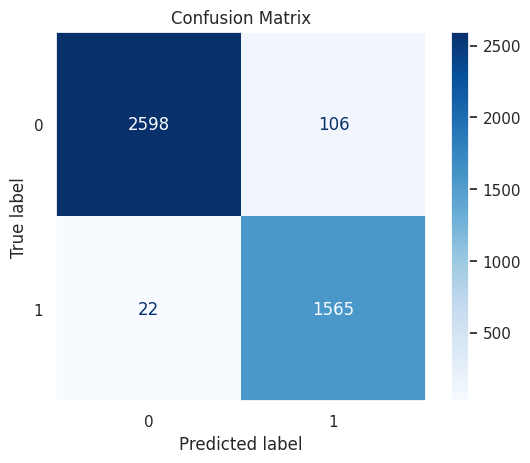


üìä Classification Report:
              precision    recall  f1-score   support

           0     0.9916    0.9608    0.9760      2704
           1     0.9366    0.9861    0.9607      1587

    accuracy                         0.9702      4291
   macro avg     0.9641    0.9735    0.9683      4291
weighted avg     0.9712    0.9702    0.9703      4291



In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# ============================
# ‚úÖ Configuration
# ============================
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ‚úÖ Load model architecture
# ============================
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDenseNet121, self).__init__()
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        self.features = base_model.features
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(base_model.classifier.in_features, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.classifier(x)
        return x

# ============================
# ‚úÖ Initialize model
# ============================
model6 = CustomDenseNet121(num_classes=2).to(DEVICE)

# ============================
# ‚úÖ Load the weights
# ============================
model6.load_state_dict(torch.load("best_model6.pth"))
model6.eval()

# ============================
# ‚úÖ Test function
# ============================
def test_model6(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100. * correct / total
    print(f"\n‚úÖ Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Classification Report
    print("\nüìä Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

# ============================
# ‚úÖ Test the model
# ============================
print("\nüöÄ Testing best model...")
test_model6(model6, test_loader)


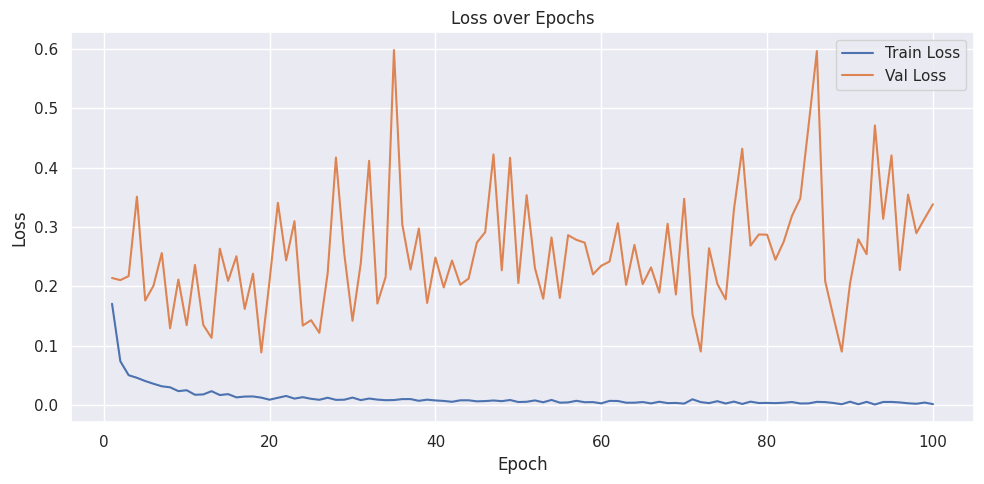

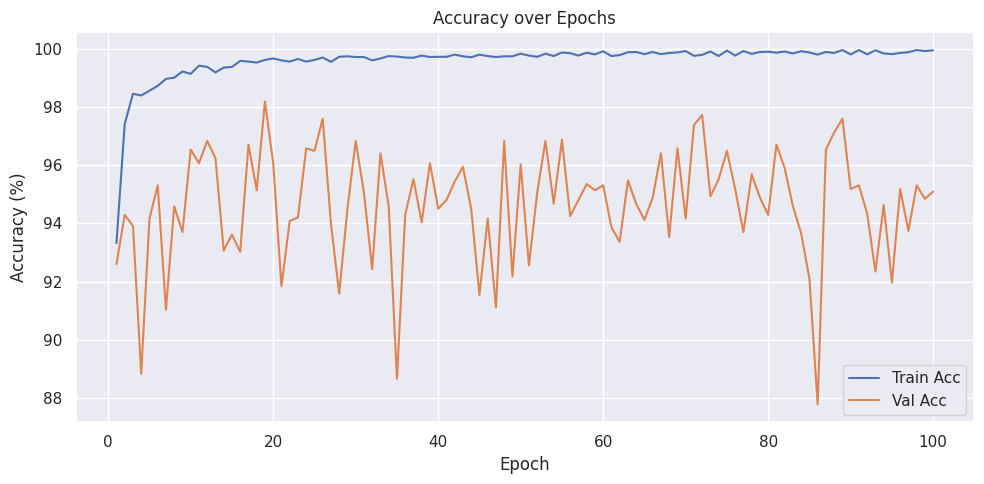

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn ‚Äúdarkgrid‚Äù theme
sns.set_theme(style="darkgrid")

# Now your original plotting code works:
epochs_range = range(1, EPOCHS + 1)

# üîπ Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses,   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# üîπ Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, [a * 100 for a in train_accuracies], label='Train Acc')
plt.plot(epochs_range, [a * 100 for a in val_accuracies],   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()